# Section 1: Preparation

**Step 1: Import Data bold text**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Master_Covid_Data.csv to Master_Covid_Data.csv


In [ ]:
import pandas as pd

In [ ]:
tweet = pd.read_csv('Master_Covid_Data.csv')

In [ ]:
tweet = tweet.iloc[:,1:]

In [ ]:
tweet.head(10)

,Tweets,Cleaned_Tweets,Cleaned_Tokens,Polarity,Sentiment,POS_Tokens,Lemmatized_Tokens
0,: The number of people in Virginia who have be...,number people virginia fully vaccinated surpas...,"['number', 'people', 'virginia', 'fully', 'vac...",0.000000,Neutral,"[('number', 'NN'), ('people', 'NNS'), ('virgin...","['number', 'people', 'virginia', 'fully', 'vac..."
1,WE DO NOT HAVE TO LIVE WITH COVID-19All of the...,live covid19all deaths next months preventable...,"['live', 'covid19all', 'deaths', 'next', 'mont...",0.068182,Positive,"[('live', 'JJ'), ('covid19all', 'NN'), ('death...","['live', 'covid19all', 'death', 'next', 'month..."
2,The point is that more than % of this bill sho...,point bill go covid going noncovid garbage rep...,"['point', 'bill', 'go', 'covid', 'going', 'non...",0.000000,Neutral,"[('point', 'NN'), ('bill', 'NN'), ('go', 'VB')...","['point', 'bill', 'go', 'covid', 'go', 'noncov..."
3,: You just stepped all over your entire show o...,stepped entire show way door vaccine far scari...,"['stepped', 'entire', 'show', 'way', 'door', '...",0.050000,Positive,"[('stepped', 'VBD'), ('entire', 'JJ'), ('show'...","['step', 'entire', 'show', 'way', 'door', 'vac..."
4,: People who work full time should be able to ...,people work full time able make living wage do...,"['people', 'work', 'full', 'time', 'able', 'ma...",0.118750,Positive,"[('people', 'NNS'), ('work', 'VBP'), ('full', ...","['people', 'work', 'full', 'time', 'able', 'ma..."
5,: RT if you agree Democrats should immediately...,rt agree democrats immediately remove everythi...,"['rt', 'agree', 'democrats', 'immediately', 'r...",0.000000,Neutral,"[('rt', 'NN'), ('agree', 'JJ'), ('democrats', ...","['rt', 'agree', 'democrat', 'immediately', 're..."
6,: Update: Weve secured million doses of AstraZ...,update weve secured million doses astrazenecas...,"['update', 'weve', 'secured', 'million', 'dose...",0.500000,Positive,"[('update', 'JJ'), ('weve', 'NN'), ('secured',...","['update', 'weve', 'secure', 'million', 'dos',..."
7,: [ENG TRANSLATION]tw // racisma german radio ...,eng translationtw racisma german radio host ta...,"['eng', 'translationtw', 'racisma', 'german', ...",-0.350000,Negative,"[('eng', 'NN'), ('translationtw', 'NN'), ('rac...","['eng', 'translationtw', 'racisma', 'german', ..."
8,: A German radio presenter equating the South ...,german radio presenter equating south korean b...,"['german', 'radio', 'presenter', 'equating', '...",-0.100000,Negative,"[('german', 'JJ'), ('radio', 'NN'), ('presente...","['german', 'radio', 'presenter', 'equate', 'so..."
9,He should have a cute little COVID hat and mask.,cute little covid hat mask,"['cute', 'little', 'covid', 'hat', 'mask']",0.156250,Positive,"[('cute', 'JJ'), ('little', 'JJ'), ('covid', '...","['cute', 'little', 'covid', 'hat', 'mask']"


**Step 2: Import JohnSnow Lab**

In [ ]:
# Install java
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!java -version

# Install pyspark
!pip install --ignore-installed -q pyspark==2.4.4

# Install Sparknlp
!pip install --ignore-installed spark-nlp

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
     |████████████████████████████████| 215.7MB 73kB/s 
     |████████████████████████████████| 204kB 22.4MB/s 
     |████████████████████████████████| 143kB 8.6MB/s 


In [ ]:
import numpy as np
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
spark = sparknlp.start()

In [ ]:
MODEL_NAME='classifierdl_use_emotion'

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = ClassifierDLModel.pretrained(name=MODEL_NAME)\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[OK!]


# Section 2: Analyze Sentiment for Topic No.1: Vaccine

In [ ]:
vaccine_twt = list(tweet[tweet['Cleaned_Tweets'].str.contains('vaccine',na=False)]['Cleaned_Tweets'])

In [ ]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)
df = spark.createDataFrame(pd.DataFrame({"text":vaccine_twt}))
result = pipelineModel.transform(df)

In [ ]:
result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|document                                                                                                                                                                                  |sentiment|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|stepped entire show way door vaccine far scarier covid                                                                                                                                    |fear     |
|update weve secured million doses astrazenecas covid19 vaccine top weve reached agre                                                                                                      |joy      |
|ivor

In [ ]:
vaccine_sen = result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment"))

In [ ]:
vaccine_sen = vaccine_sen.toPandas()

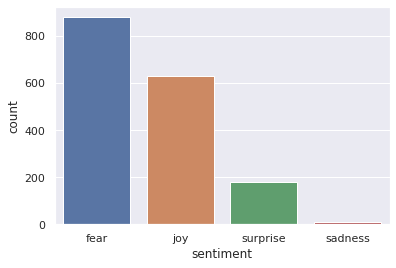

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=vaccine_sen)

# Section 3: Analyze Sentiment for Topic No.2: Relief

In [ ]:
relief_twt = list(tweet[tweet['Cleaned_Tweets'].str.contains('relief',na=False)]['Cleaned_Tweets'])

In [ ]:
empty_df = spark.createDataFrame([['']]).toDF("text")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

pipelineModel = nlpPipeline.fit(empty_df)
df = spark.createDataFrame(pd.DataFrame({"text":relief_twt}))
result = pipelineModel.transform(df)

In [ ]:
result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|document                                                                                                                                                                          |sentiment|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|rt agree democrats immediately remove everything related covid relief covid relief bill                                                                                           |fear     |
|order preserve must keep 15 min wage covid relief bill otherwise likely dea                                                                                                       |surprise |
|political cartoon day going piggy bank old s

In [ ]:
relief_sen = result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment"))

In [ ]:
relief_sen = relief_sen.toPandas()

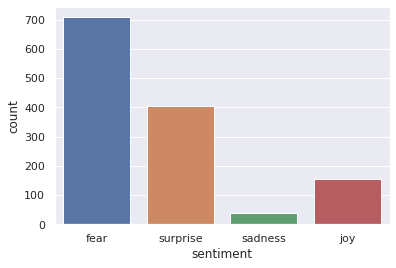

In [ ]:
ax = sns.countplot(x="sentiment", data=relief_sen)

# Section 4: Analyze Sentiment for Topic No.3: Jeremy Lin / Lin

In [ ]:
Lin_twt = list(tweet[tweet['Cleaned_Tweets'].str.contains('lin',na=False) & tweet['Cleaned_Tweets'].str.contains('jeremy',na=False)]['Cleaned_Tweets'])

In [ ]:
empty_df = spark.createDataFrame([['']]).toDF("text")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

pipelineModel = nlpPipeline.fit(empty_df)
df = spark.createDataFrame(pd.DataFrame({"text":Lin_twt}))
result = pipelineModel.transform(df)

In [ ]:
result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment")).show(truncate=False)

+---------------------------------------------------------------------------------------+---------+
|document                                                                               |sentiment|
+---------------------------------------------------------------------------------------+---------+
|year nba veteran doesnt protect called coronavirus courtjeremy lin detailed racism tha |fear     |
|year nba veteran doesnt protect called coronavirus courtjeremy lin detailed racism tha |fear     |
|year nba veteran doesnt protect called coronavirus courtjeremy lin detailed racism tha |fear     |
|year nba veteran doesnt protect called coronavirus courtjeremy lin detailed racism tha |fear     |
|right f called jeremy lin coronavirus court                                            |sadness  |
|nba player think called jeremy lin coronavirus basketball court bonus points sjw slogan|fear     |
|year nba veteran doesnt protect called coronavirus courtjeremy lin detailed racism tha |fear     |


In [ ]:
lin_sen = result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentiment"))

In [ ]:
lin_sen = lin_sen.toPandas()

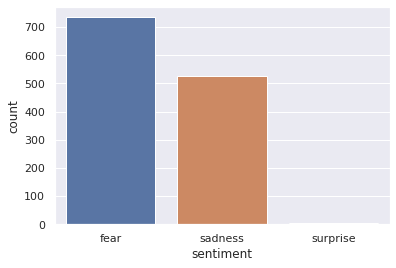

In [ ]:
ax = sns.countplot(x="sentiment", data=lin_sen)